### Data visualization

In [2]:
path = 'C:/Users/Haiya/Downloads/535/'
file = path + 'redcap 535 median 24 hours.csv'

### Read and Visualize SO2-2 and SO2-1

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycwt import wavelet
import math
import numpy as np
import matplotlib.pyplot as plt
import pywt


In [15]:
def convert_time_to_seconds_pure(df, time_col):
    """
    Parse 'MM/DD/YYYY HH:MM' or 'MM/DD/YYYY HH:MM:SS' (optionally with AM/PM)
    without using pd.to_datetime. Returns seconds from the first valid time.
    Ignores year; uses a simple month/day offset to keep ordering.
    Missing/invalid -> None.
    """
    out = []

    for s in df[time_col]:
        # handle NaN/None/non-string
        if s is None or (isinstance(s, float) and math.isnan(s)):
            out.append(None); continue
        if not isinstance(s, str):
            s = str(s)
        s = s.strip()
        if not s:
            out.append(None); continue

        parts = s.split()
        if len(parts) < 2:
            out.append(None); continue

        date_part, time_part = parts[0], parts[1]
        ampm = parts[2].lower() if len(parts) >= 3 else None  # optional AM/PM

        try:
            # date
            m, d, *_ = [int(x) for x in date_part.split('/')]   # ignore year
            # time
            tparts = time_part.split(':')
            if len(tparts) == 2:
                hh, mm = int(tparts[0]), int(tparts[1])
                ss = 0
            elif len(tparts) == 3:
                hh, mm, ss = int(tparts[0]), int(tparts[1]), int(tparts[2])
            else:
                raise ValueError

            # 12h clock support if AM/PM present
            if ampm in ('am', 'pm'):
                if ampm == 'pm' and hh != 12:
                    hh += 12
                if ampm == 'am' and hh == 12:
                    hh = 0

            # crude absolute seconds (ignore real month lengths; just need ordering)
            total_seconds = ((m - 1) * 31 * 24 * 3600) + ((d - 1) * 24 * 3600) + hh * 3600 + mm * 60 + ss
            out.append(total_seconds)

        except Exception:
            out.append(None)

    # shift so first valid becomes 0
    valid = [t for t in out if t is not None]
    if valid:
        start = valid[0]
        out = [(t - start) if t is not None else None for t in out]

    df[time_col] = out
    return df


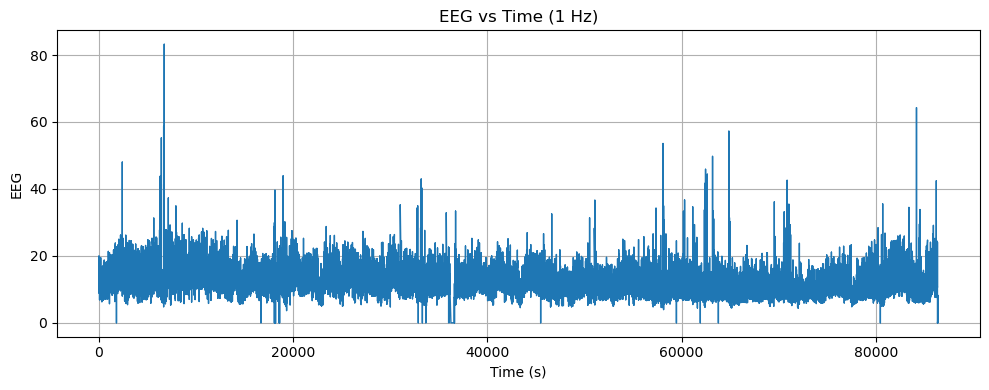

In [20]:
df = pd.read_csv(file, header=None, names=['Time', 'EEG'])
df = convert_time_to_seconds_pure(df, 'Time')
df['Time'] = df['Time'] - df['Time'].min()
plt.figure(figsize=(10, 4))
plt.plot(df['Time'], df['EEG'], lw=1)
plt.xlabel('Time (s)')
plt.ylabel('EEG')
plt.title('EEG vs Time (1 Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

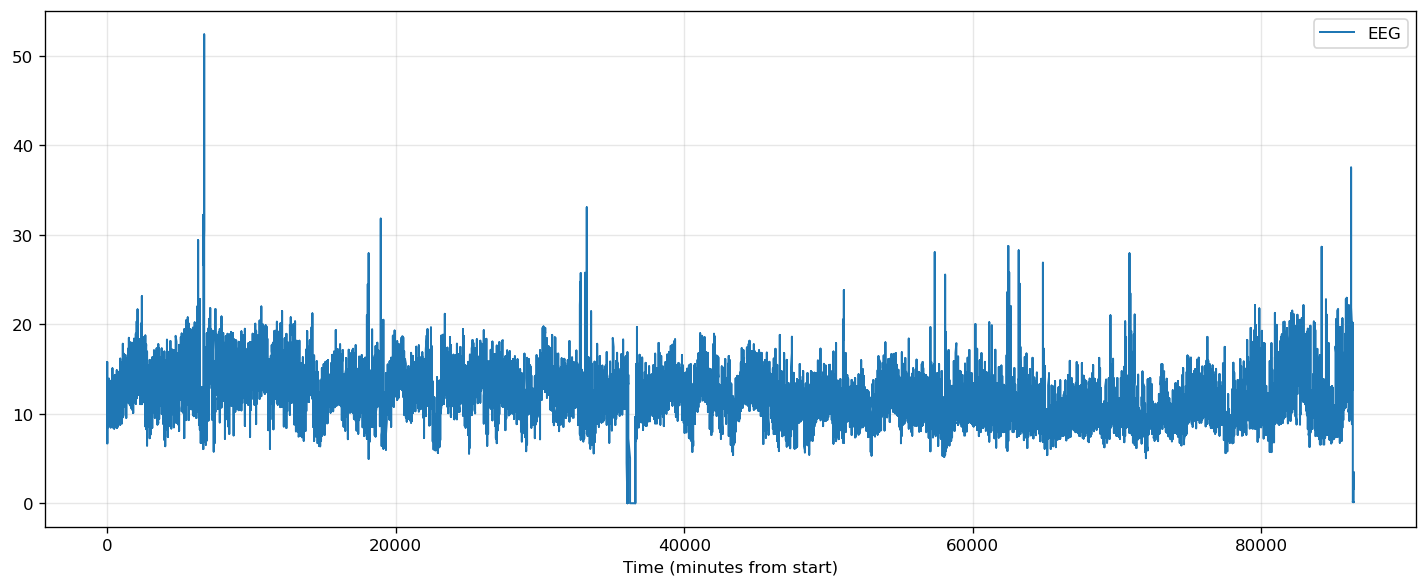

In [30]:
def moving_average(a, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(a, kernel, mode='same')

x = df['Time']
EEG_smo = moving_average(df['EEG'].to_numpy(), window_size=5)
plt.figure(figsize=(12, 5), dpi=120)
plt.plot(x, EEG_smo, label='EEG', lw=1.2)
plt.xlabel(xlabel)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

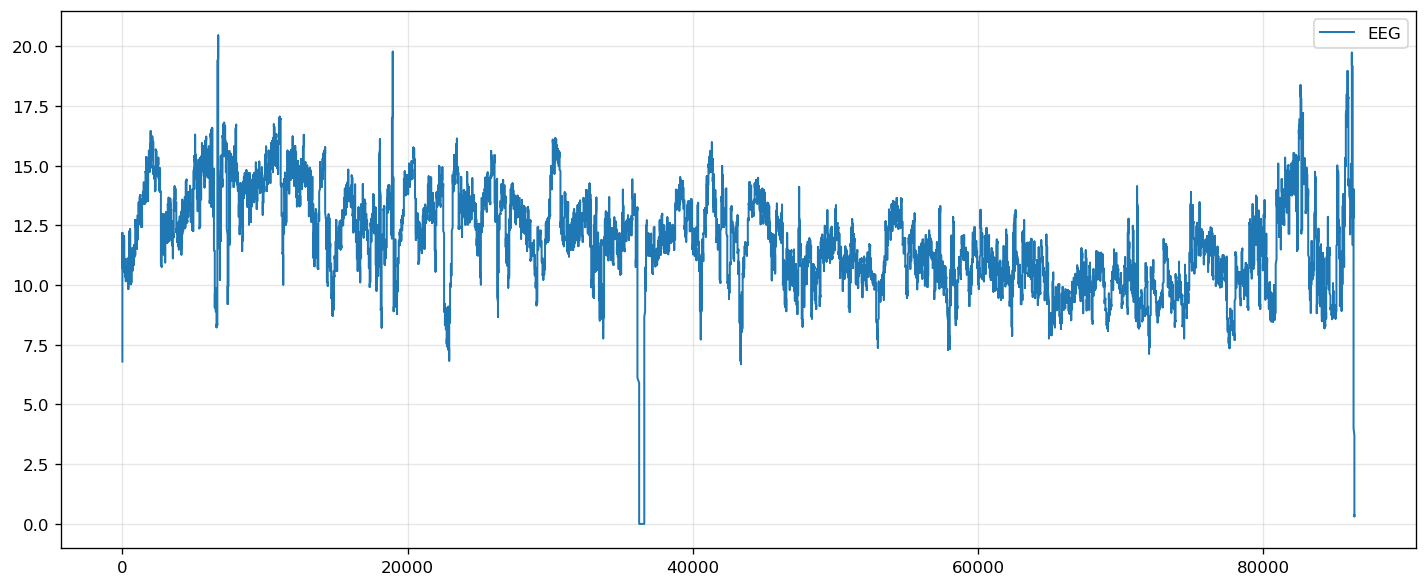

In [32]:
x = df['Time']
xlabel = 'Time (minutes from start)'
EEG_smo = moving_average(df['EEG'].to_numpy(), window_size=60)
plt.figure(figsize=(12, 5), dpi=120)
plt.plot(x, EEG_smo, label='EEG', lw=1.2)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Continuous Wavelet Transform

signal length: 86091
CWT coeffs shape: (999, 86091)


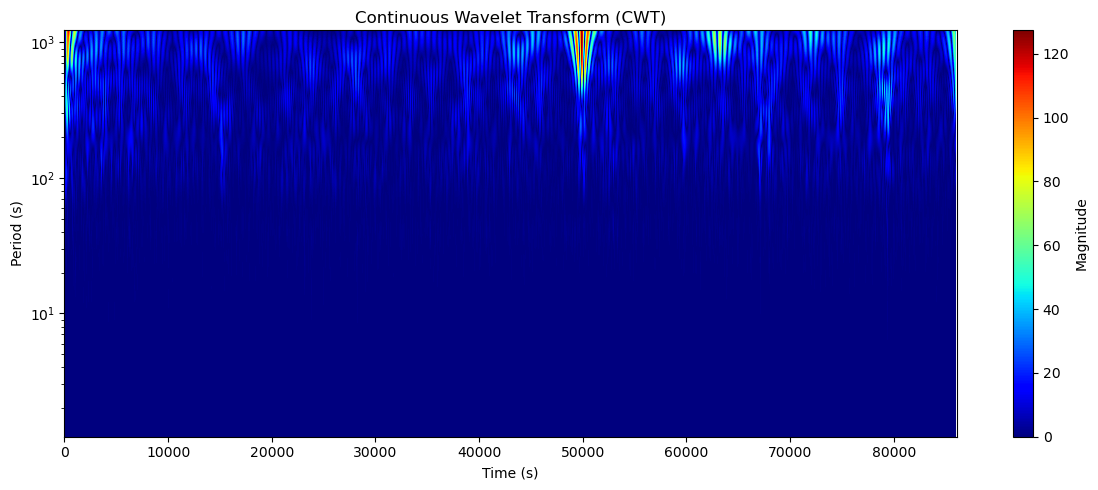

In [50]:
fs = 1.0  # Hz
signal = np.asarray(EEG_smo).astype(float)
N = signal.shape[0]
t = np.arange(N) / fs
scales = np.arange(1, 1000)

# Continuous Wavelet Transform
coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/fs)  # coeffs: (n_scales, N)
power = np.abs(coeffs)
period = 1.0 / freqs

print("signal length:", N)
print("CWT coeffs shape:", coeffs.shape)  # (n_scales, N)

# Plot
plt.figure(figsize=(12, 5))
extent = [t[0], t[-1], period.min(), period.max()]  # small period (high f) at bottom
im = plt.imshow(power, extent=extent, aspect='auto', origin='lower', cmap='jet')
plt.yscale('log')
plt.ylabel('Period (s)')
plt.xlabel('Time (s)')
plt.title('Continuous Wavelet Transform (CWT)')
plt.colorbar(im, label='Magnitude')
plt.tight_layout()
plt.show()

signal length: 86091
CWT coeffs shape: (999, 86091)


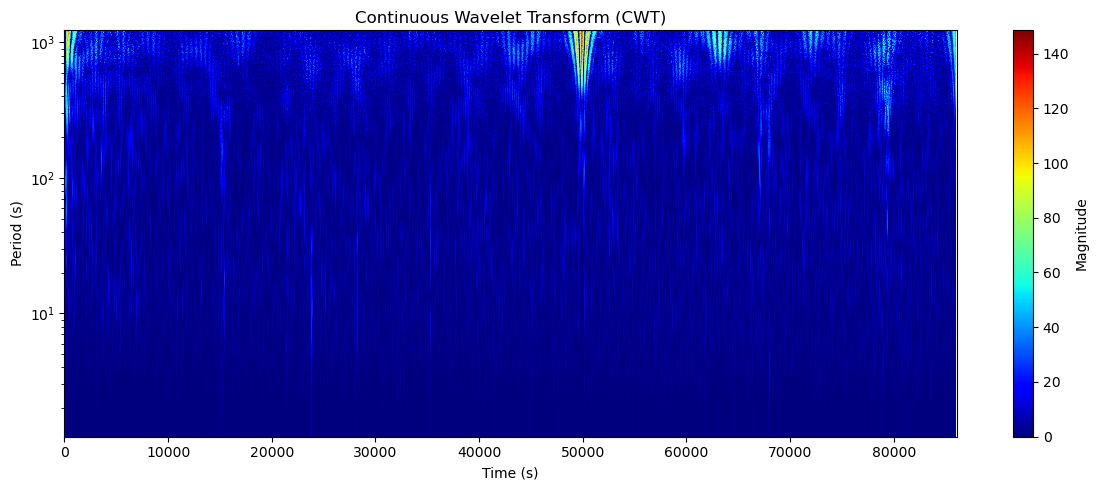

In [51]:
fs = 1.0  # Hz
signal = np.asarray(df['EEG']).astype(float)
N = signal.shape[0]
t = np.arange(N) / fs
scales = np.arange(1, 1000)

# Continuous Wavelet Transform
coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/fs)
power = np.abs(coeffs)
period = 1.0 / freqs

print("signal length:", N)
print("CWT coeffs shape:", coeffs.shape)

# Plot
plt.figure(figsize=(12, 5))
extent = [t[0], t[-1], period.min(), period.max()]
im = plt.imshow(power, extent=extent, aspect='auto', origin='lower', cmap='jet')
plt.yscale('log')
plt.ylabel('Period (s)')
plt.xlabel('Time (s)')
plt.title('Continuous Wavelet Transform (CWT)')
plt.colorbar(im, label='Magnitude')
plt.tight_layout()
plt.show()